# Modelling Mathematical Theorems
by Douglas Sherman
### Goals
* Determine if there is a trend among theorems of similar fields of Mathematics
* What are the most similar fields of Mathematics
* Build a predictive model to determine a field by commonly used words
* Use the predictive model to study interesting classes of Theorems
* Demonstrate the utility of the model by re-classifying Theorems

## Data Wrangling

#### Getting the data

To get the Math Theorems, we scraped the Wikipedia page <a href="https://en.wikipedia.org/wiki/List_of_theorems">List of Theorems</a>. From here we recognized that there was a standard <tt>mw-content-ltr</tt> class in which the body of each page was located in. The following scapes the List of Theorems page, removes the header and footer, and then builds a data frame by scraping the pages at the links of each of the Theorems.

In [94]:
theorems[0:3]

,Field,Link,Page,Title,Trimmed
0,algebraic geometry,/wiki/AF%2BBG_theorem,"<div class=""mw-content-ltr"" dir=""ltr"" id=""mw-c...",AF+BG theorem,"In algebraic geometry, a field of mathematics,..."
1,number theory,/wiki/ATS_theorem,"<div class=""mw-content-ltr"" dir=""ltr"" id=""mw-c...",ATS theorem,"In mathematics, the ATS theorem is the theorem..."
2,combinatorics,/wiki/Abel%27s_binomial_theorem,"<div class=""mw-content-ltr"" dir=""ltr"" id=""mw-c...",Abel's binomial theorem,This mathematics-related article is a stub. Yo...


#### Data Pre-Processing

Once we had the html of each of the theorems, we needed to clean this text substantially in order analyze it. To do this we first replaced any unicode titles with their <tt>string</tt> equivalents, then we trimmed any theorems that were part of obscure fields of Mathematics (for example Lie Algebra, Metric Geometry, or Elliptic Differential Equations). Still, we couldn't train the the html data as is. First, this data has all the html formatting tags such as <"p"> and <"div">. Beautiful Soup remove's these by the <tt>.get_text()</tt> function. This is demonstrated in the _Trimmed_ column of the theorems data frame.

Second, this is Mathematics and as such it contains a substantial amount of Math in each of the pages. Not only is this math not easily translated into words, it is formatted by the standard <tt>TeX</tt> formatting which looks like <tt>\forall x \in \mathbb{R}</tt> to produce $\forall x \in \mathbb{R}$. To fix this we first removed the html formatting with get_text(), then used regular expressions to remove any brakets or other formatting that is present in a standard TeX script. However, this still left the above expression as <tt> forall x in mathbb R </tt>. Then to remove the extraneous words that were part of the TeX commands, we scraped a LaTeX glossary of commands and added these words to our collection of stopwords (used later for classification and word clouds). This glossary can be found <a href="https://en.wikibooks.org/wiki/LaTeX/Command_Glossary">here</a>.

## Most Common Words

Next we used the nltk package to build word clouds and bar graphs of the most common words across all theorems in a given field of Mathematics. The stop words contained words like which, the, math, and most importantly, all the TeX words scrapped from the online glossary. 

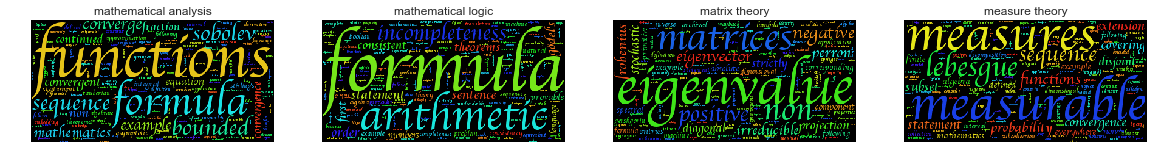

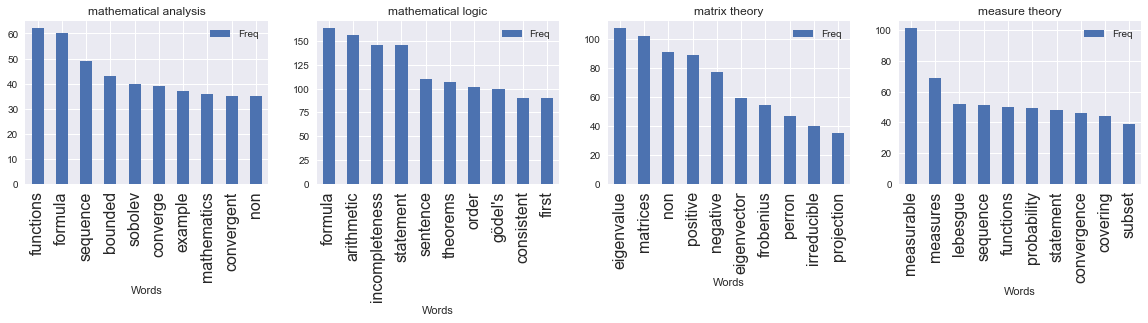

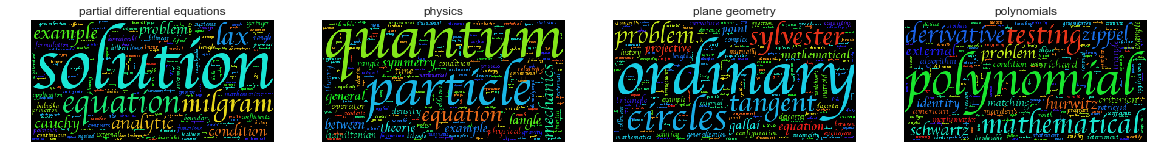

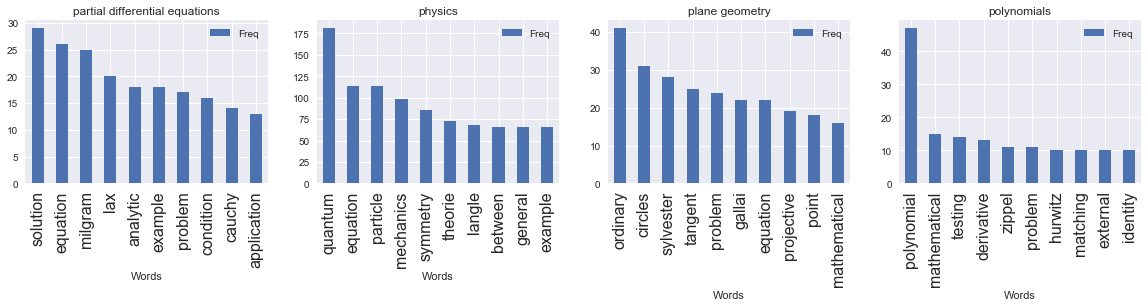

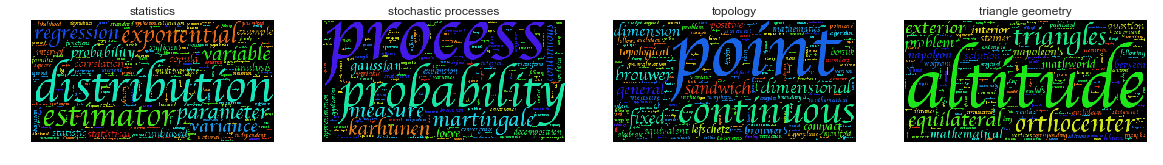

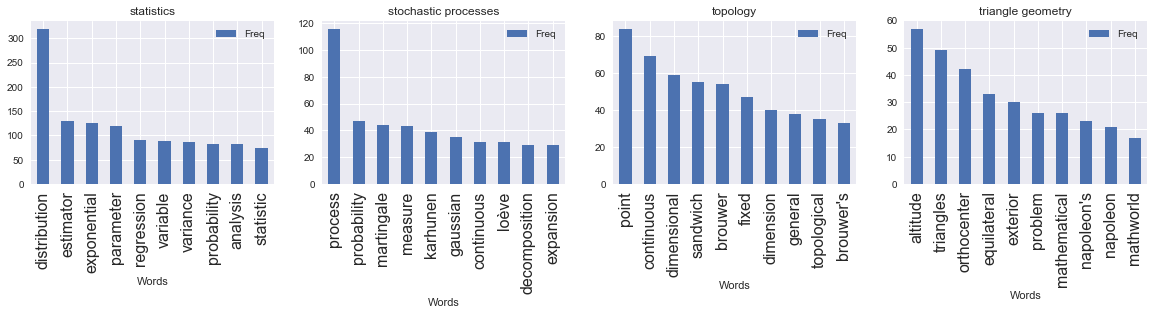

In [101]:
plotWordClouds()

Some of the fields' most common words are not very surprising. Such as distribution for Statistics or formula for Mathematical Logic. However, the Physics field produced quantum as the most common word, which indicates how important quantum is for Physics proofs. Also in Measure theory we see Lebesque, as in the Lebesque measure, which is interesting as this Measure is so important to measure theory that it trumps words like probability and function. 

## Similarity of Fields

Next we measured the similarity of each field of Mathematics based on each fields' most common words. First we built a dictionary that looked at each word among all Theorems and found which Theorems shared that particular word among their top words. This dictionary is then turned into a data frame, below shows how many fields have the Keys as part of their top words. Below is a list of the ten most shared words among the fields and how many fields shared that particular word, or Key.

In [103]:
shared_words[0:10]

,Keys,Length
1506,mathemat,53
2022,exampl,45
1297,statement,43
538,gener,39
382,applic,38
1082,follow,37
74,springer,36
906,extern,34
825,between,34
2115,function,33


Once we had these shared words, we could compute a similarity metric between the Theorems. The metric we selected is as follows. For $n$ total fields and $\nu$ total words, the similarity matrix for the fields of Mathematics, $Sim = [s_{ij}] \in \mathbb{R}^{n\times n}$, is given by,

$$s_{ij} = \frac{\sum_{k=1}^\nu \gamma_{ij}(w_k) }{\sqrt{2m_i m_j}};\quad\quad \gamma_{ij} = \left\lbrace
\begin{matrix} 
1&\text{if}&w_k\in F_i \cap F_j \\
0&\text{if}&i=j\\
0&\text{if}&w_k\notin F_i\cap F_j\
\end{matrix}\right.$$

where $F_i$ is the set of words for Field $i$, $w_k$ is the $k$th word, and $\beta$ is a scaling factor to force $s_{ij}\in [0,1]$. With this metric we get values around [0,1] and the similarity is scaled by how many words are in each field. Below computes that similarity matrix and displays it as a graph of intensity. 

,Max,Field_1,Field_2
28,1.010641,graph theory,model theory
37,1.010641,number theory,graph theory
10,0.999890,complex analysis,model theory
44,0.918733,probability,probability
45,0.918733,probability theory,probability
41,0.911435,physics,number theory
24,0.891479,functional analysis,complex analysis
2,0.857754,algebraic geometry,graph theory
29,0.857754,group theory,algebraic geometry
27,0.839447,geometry,partial differential equations


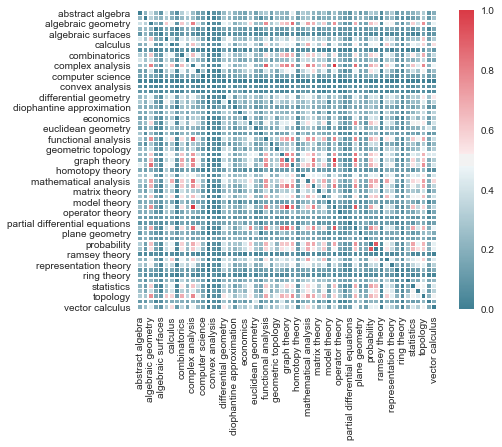

In [109]:
import seaborn as sns
# Generate a custom diverging colormap
svm_cmap = sns.diverging_palette(220, 10, as_svm_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sim = pd.DataFrame(sim).rename(index=str,columns={x:y for x,y in enumerate(fields)}).set_index(keys=fields)
sns.heatmap(sim, svm_cmap=svm_cmap, vmax=1, cbar = True,
            square=True, xticklabels=2, yticklabels=2,
            linewidths=.5)

max_sim[0:10][['Max','Field_1','Field_2']]

The similarity matrix shows that there were a few Theorems that were very similar, such as Graph and Model theory, but the majority of pairs are blue with a similarity of less than 0.5. Some not so intuitive results are that Physics and Number theory were very similar, as well as Geometry and PDEs. Group theory is just Algebra, so to be categorized with Algbraic Geometry was not very surprising.

## Classifying Fields of Mathematics

Next we built a classifer to predict the field of Mathematics that a theorem belongs to. We tested using bag of words or just the top words of each field with both Multinomial Naive Bayes and SVM models. 

#### Fitting Models to Bag of Words

Using a bag of words as a feature set we check both the Multinomial Naive Bayes (MNB) and SVM models. The SVM model fits multiple classes in 1 vs all fashion as it is a binary classifier. Hence it checks each Theorem against each field and returns the most likely field.

In [25]:
temp = test_clf(new_duplicate,NB,None)
print 'MNB:',{x:round(y,4) for x,y in temp.items()}

svm_svm_cm = test_clf(new_duplicate,SVM,None)
print 'SVM:',{x:round(y,4) for x,y in svm_svm_cm.items()}

MNB: {'Sensitivity': 0.0631, 'Accuracy': 0.1186, 'Precision': 0.1186, 'Fallout': 0.4407, 'Specificity': 0.2121}
SVM: {'Sensitivity': 0.0296, 'Accuracy': 0.5835, 'Precision': 0.5835, 'Fallout': 0.0091, 'Specificity': 0.9847}


Since the accuracy was significantly lower than desired, but the SVM model was clearly better than the MNB model. We then tuned the SVM model's hyper-parameters using a grid search in order produce the best model.

{'Best Random State': 40.0, 'Best Alpha': 0.0001, 'Best Num Iter': 23.0}


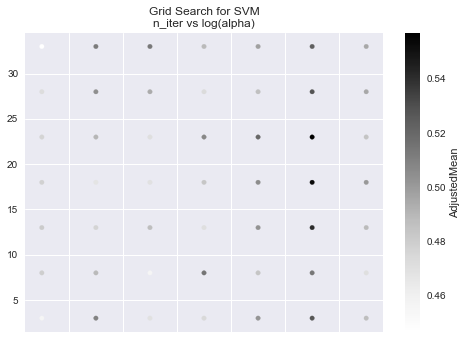

In [68]:
plotGridSearch()

#### Running Multinomial Naive Bayes on Top Words

Next we tried running the models on just the top words of each field rather than the whole bag of words approach. Since this produces a new hyper-parameter, <tt>top_x</tt>, which dictates how many of the top words are used in the model, we used this hyper-parameter to train ROC curves. We built both ROC and Precision-Recall curves as well as plotted the accuracy for the various values of <tt>top_x</tt>. 

{'Max: ': '0.878934624697', 'Mean: ': '0.820636990129', 'Min: ': '0.685230024213'}


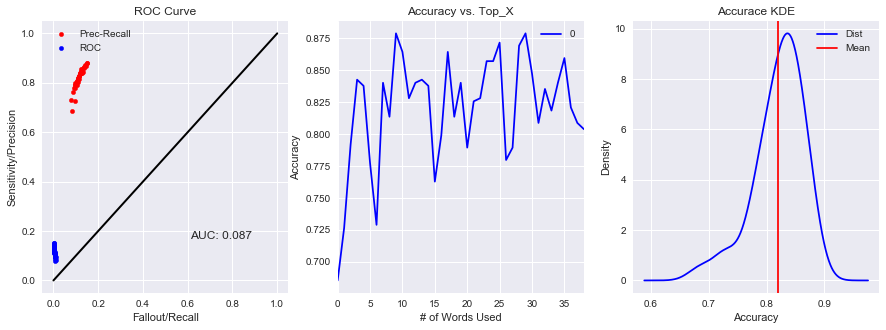

In [116]:
plotMNB()

We defintely see improvement from the bag of words model, but the area under the ROC curve is abysmal and the accuracy could be better.

#### Running SVM on Top Words

After determining the best values for <tt> rand_state, n_iter,</tt> and <tt> alpha </tt> we ran the tuned SVM model on just the top words of each field tuning the <tt>top_x</tt> hyper-parameter to build the ROC curve.

{'Max: ': '1.0', 'Mean: ': '0.98615508785', 'Min: ': '0.782082324455'}


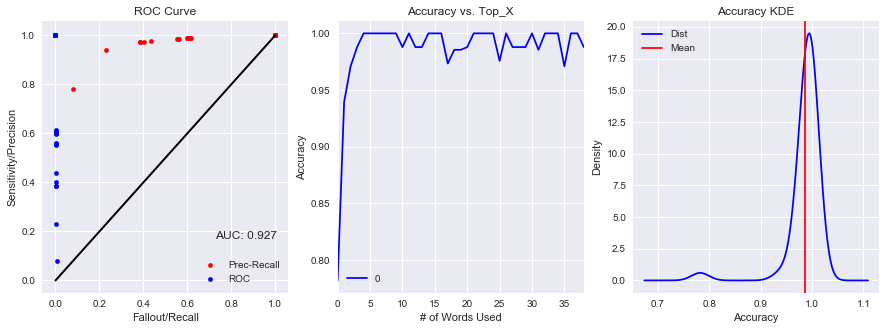

In [117]:
plotSVM()

Here we see that the accuracy and ROC curve are far superior with the topwords SVM model over the MNB model. This could be partly due to the fact that MNB relies on the features (words) being independent from each other which is not necesarily a good assumption. This is because a theorems choice of wording could affect all other words in the Theorem. For example, a linear algebra theorem could discuss a function as a map or an operator depending on if it is a theorem discusses the linearity of functions, a map between two vector spaces, or a Hermitian operator. In all these cases, the theorem should clearly be classified as Linear Algebra but has vastly different wording. The SVM model makes no such assumption, and it quickly weights non-informative features to zero, leaving only the big words playing a role in the classification. This is seen as the accuracy quickly rises to nearly 100% at only about 7 top words while the MNB model needs 27 to get close to the same accuracy. This is also reflected in the area under the ROC curve (AUC). For MNB this is only 0.091, significantly smaller than the ideal 1.0, while the SVM model gets much closer at 0.711. The reason for MNB's low AUC is that recall just never makes it past 20%. The recall, or true positive rate, is very lower for MNB. Since this value is computed of the recall of choosing each class as true, with the remaining set to false, this demonstrates the lack of granularity in the MNB model. For each of these recall calculations, we have only a handful true classes and mostly false classes, so the MNB model simply markes these as true instead of tweaking its weights to handle such a small number of responses. Both models had very lower Fallouts (or false positive rates), thus a misclassifed positive value was very unlikely. This is again most likely due to the 1 vs all method of multi-class classification; it was so unlikely to label anything as true, thus it was even more unlikely to label the wrong sample as true.

## The Most Beautiful Theorems

Following an article on the most "Beautiful" theorems of Mathematics from <a href=https://www.quora.com/Which-are-the-most-beautiful-mathematical-theorems-and-why target='_blank'>www.quora.com</a>, the following illustrates some traits of all these theorems as a collection. Quora asked people to consider the following when selecting theorems for the list

| Category | Description|
|----------|------------|
|_Generality_ | it is applicable to a wide variety of problems.|
|_Succinctness_|  it is expressible simply, in only a few words or equations.|
|_Originality_ | it expresses a surprising mathematical insight, or a connection between different areas of mathematics, that had not previously been widely suspected.|
|_Significance_ | it represents an important advance in mathematical knowledge, or resolves an important mathematical problem.|
|_Potency_ | it stimulates many new areas of mathematical research.|
|_Centrality_ | it is used in the proofs of many subsequent theorems.|
|_Independence_ | its proof depends on only a small number of previously established theorems, and preferably none.|

The theorems that were selected were
<center>
The Pythagorean Theoem (Geometry, Pythagoras),
Euclid's Theorem of the Infinitude of Primes (Number Theory, Euclid), The Minimax Theorem (Game Theory, John von Neumann),The Brouwer Fixed Point Theorem (Topology, Luitzen Brouwer),Cauchy's Residue Theorem (Complex Analysis, Augustin-Louis Cauchy),Fourier's Theorem (Function Theory, Joseph Fourier),The Halting Theorem (Computability Theory, Alan Turing),Gödel's Incompleteness Theorems (Mathematical logic/Metamathematics, Kurt Godel),Schubert's Prime Knot Factorization Theorem (Knot Theory, Horst Schubert),Cantor's Theorem (Set Theory/Transfinite Analysis, Georg Cantor),Fundamental Theorem of Algebra (Algebra)
</center>

For this web page, the Theorems and which category they satisfy from the above list are bolded. Thus by scraping the page for the <tt> <"b"> </tt> tag we can get the relevant information after trimming the header (first 7 lines). Moreover, to make the theorem titles match the pre-existing data theorems frame, we had to do some serious trimming. This is done be first correcting any spelling errors, i.e. theoem instead of theorem, and stripping trailing white spaces as well as 'The' from each title.

Even after trimming the titles, there were still some that were names differently than our data frame. For example, Residue theorem was called Cauchy's Residue theorem. So we had to correct these titles before searching our data frame for their text. After fixing the titles we could join this list of Beautiful Theorems with the associated "reasons" for being beautiful with our pre-existing data frame.

In [119]:
BeautifulThms[0:5]

,Field,Link,Page,Title,Trimmed,Reasons
147,topology,/wiki/Brouwer_fixed_point_theorem,"<div class=""mw-content-ltr"" dir=""ltr"" id=""mw-c...",Brouwer fixed point theorem,Brouwer's fixed-point theorem is a fixed-point...,centrality
877,complex analysis,/wiki/Residue_theorem,"<div class=""mw-content-ltr"" dir=""ltr"" id=""mw-c...",Residue theorem,"In complex analysis, the residue theorem, some...",closure
164,set theory,/wiki/Cantor%27s_theorem,"<div class=""mw-content-ltr"" dir=""ltr"" id=""mw-c...",Cantor's theorem,"The cardinality of the set y, is three, while ...","generality, succinctness, originality, signifi..."
387,complex analysis,/wiki/Fundamental_theorem_of_algebra,"<div class=""mw-content-ltr"" dir=""ltr"" id=""mw-c...",Fundamental theorem of algebra,Not to be confused with Fundamental theorem of...,"generality, originality, significance, potency..."
319,number theory,/wiki/Euclid%27s_theorem,"<div class=""mw-content-ltr"" dir=""ltr"" id=""mw-c...",Euclid's theorem,Euclid's theorem is a fundamental statement in...,"succinctness, originality, significance, poten..."


Then we plotted the most common words in all of these Beautiful Theorems. 

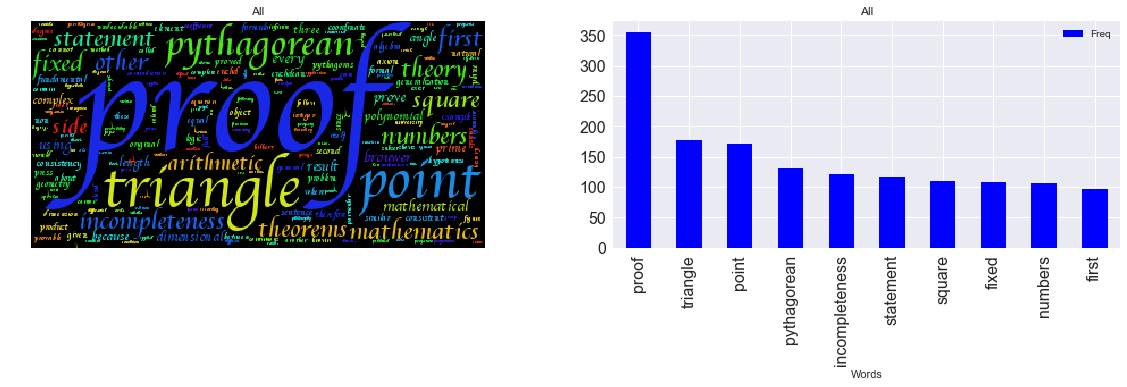

In [120]:
plotBeautifulWordClouds()

There isn't much that can be gained from these plots, but one interesting feature is that the word "proof" was by far the most common word, nearly doubling second place. This is pretty clear when you consider that a theorem must be proven, but more importantly this didn't show up in the other word clouds. Thus this likely demonstrates that there is minimal similarity between the Beautiful theorems as it stretching to find a word that is shared between them. 

To test how similar these Theorems were we computed the similarity between them just as before. Since this was from Theorem to Theorem, there are much less words to compute on, but still we were able to determine very similar Theorems and very dissimilar Theorems.

In [121]:
BeautySim[0:5]

,F1,F2,Key1,Key2,R1,R2,Sim,T1,T2
9,complex analysis,number theory,10,37,closure,"succinctness, originality, significance, poten...",0.999890,Residue theorem,Euclid's theorem
18,complex analysis,number theory,10,37,"generality, originality, significance, potency...","succinctness, originality, significance, poten...",0.999890,Fundamental theorem of algebra,Euclid's theorem
22,number theory,mathematical logic,37,33,"succinctness, originality, significance, poten...","generality, originality, centrality, significance",0.811729,Euclid's theorem,Gödel's incompleteness theorem
0,topology,complex analysis,54,10,centrality,closure,0.789424,Brouwer fixed point theorem,Residue theorem
2,topology,complex analysis,54,10,centrality,"generality, originality, significance, potency...",0.789424,Brouwer fixed point theorem,Fundamental theorem of algebra


Many of the theorems in this class are very similar, such as complex analysis, number theory, and mathematical logic. These fields are considered as part of the backbone of formal mathematics, which could explain why these were selected as "Most Beautiful". Moreover, being the backbone, and since _independence_ was a category for selection, these don't rely on pre-existing Mathematics; leaving minimal phrasing for building these theories and making them similar.

Next we looked at the most common "reasons" for beautfulness among the Theorems. We plotted two sets of plots; one for all the theorems, and one for just the most similar theorems. 

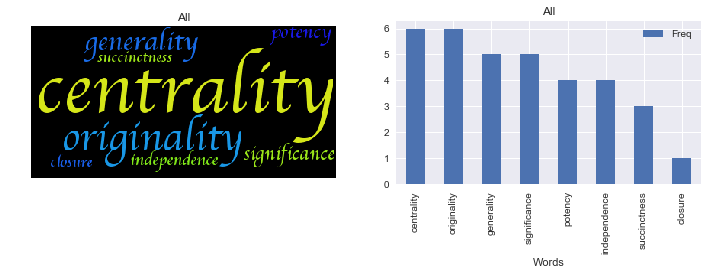

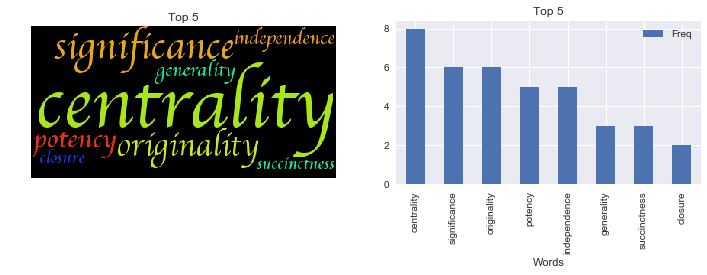

In [61]:
SimilarReasons()

There weren't many words to begin with, but there is a clear divide between the two sets as far as distributions go. For the second plot, significance started to play a much larger role than in the first. Moreover, originality fell from importance in the most similar categories. This makes sense, since if they were too original, they wouldn't be labeled as similar. 

We then used our trained SVM model to learn more about the beautiful theorems. First we checked the accuracy of the model in correctly predicting their fields, and then we checked what field of Mathematics would be predicted by combining all the beautiful theorems into one. 

In [72]:
beauty_svm_cm

{'Accuracy': 0.875,
 'Precision': 0.875,
 'Sensitivity': 0.5,
 'Specificity': 0.97999999999999998}

Here wee see that the accuracy, precision, sensitivity, and specificity are all much less than the mean accuracy for the SVM model. This could be because there is a distinct difference between these "Beautiful" theorems and the standard formulaic theorems as a whole. Succinctness and originality were both categories in this list and both of these play against our model by not providing enough words and not providing similar words compared to other theorems in their respective fields. Moreover, theorems like the Fundamental Theorem of Algebra are about Algebra, but because these are the building blocks for Algebra all the algebraic tools built from them, so it requires the use of arithmetic and number theory in their proofs.

In [75]:
## Classify all the Beauty Theorems into one
beauty_all = sklearn.datasets.base.Bunch(
                    description="All Beautiful",
                    filenames="",
                    target_names="All",
                    data=[" ".join(beauty_df.data)],
                    target=-1)
pred_all = clf.predict(beauty_all.data)
{x:y for x,y in enumerate(fields) if x == pred_all}

{33: 'mathematical logic'}

Finally the overarching field that most represents all the Beautiful theorems as a whole in Mathematical Logic. Fitting as all of Mathematics pulls from this field. Hence, Mathematical logic would likely be a strong contender in a more subjective classification of the most beautiful theorems. Moreover, Mathematical Logic the independence reason for selecting a Beautiful Theorem leaves mathematical logic as the most likely field to pull from as it is the foundation of all other mathematics. 

## Re-Categorizing Odd Fields

In the pre-processing step, we removed any theorems that were a part of some obscure field of Mathematics (per Wikipedia). The following will try to re-classify those Theorems into more appropriate fields so that they can be included with their fellow theorems. For example the field Quantum Theory really should be lumped in with Physics, and 'Several Complex Variables' is just Complex Analysis.

In [124]:
removed_thms.iloc[[1, 2, 5, 266, 279, 286]+range(10,15)][['Field','Title','Predicted']].sort_index()

,Field,Title,Predicted
10,mathematical series,Absolute convergence theorem,mathematical analysis
14,lie algebra,Ado's theorem,abstract algebra
33,queueing theory,Arrival theorem,stochastic processes
60,"metric spaces, differential equations",Banach fixed point theorem,order theory
70,spectral theory,Bauer–Fike theorem,linear algebra
73,vector bundles,Beauville–Laszlo theorem,homotopy theory
74,category theory,Beck's monadicity theorem,algebraic topology
75,incidence geometry,Beck's theorem (geometry),algebraic surfaces
1019,axiom of choice,Szpilrajn extension theorem,model theory
1064,neural networks,Universal approximation theorem,ergodic theory


From the table above we see that the predicted fields sometimes do not agree with what we would guess subjectively. It is not surprising that  subjects like Lie Algebra, Queuing Theory, and Mathematical Series get predicted as Abstract Algebra, Stochastic Processes, and Analysis respectively. However, the classification of fields like Axiom of Choice, Neural Networks, and Quadratic Forms as Model Theory, Partial Differential Equations, and Number Theory, didn't agree with our first guesses of their parent fields. This is a demonstration that this isn't a classification of the field itself, but the theorem that Wikipedia classified as that original field. For example the Neural Network theorem was the "Universal approximation theorem" which describes 

>"In the mathematical theory of artificial neural networks, the universal approximation theorem states[1] that a feed-forward network with a single hidden layer containing a finite number of neurons (i.e., a multilayer perceptron), can approximate continuous functions on compact subsets of $\mathbb{R}^n$, under mild assumptions on the activation function. The theorem thus states that simple neural networks can represent a wide variety of interesting functions when given appropriate parameters; however, it does not touch upon the algorithmic learnability of those parameters.

>One of the first versions of the theorem was proved by George Cybenko in 1989 for sigmoid activation functions.[2]

>Kurt Hornik showed in 1991[3] that it is not the specific choice of the activation function, but rather the multilayer feedforward architecture itself which gives neural networks the potential of being universal approximators. The output units are always assumed to be linear. For notational convenience, only the single output case will be shown. The general case can easily be deduced from the single output case."          
~<a href="https://en.wikipedia.org/wiki/Universal_approximation_theorem">Universal Approximation Theorem</a>

Now the wording of this quote starts to provide insight into why this was classifed as a PDE theorem. This provides some valuable uses for this prediction algorithm. First of all, the publisher of these Theorems only thought of the single use of the intended Theorem, and using this prediction model we can find other fields of Mathematics that these Theorems support. Moreover, if someone studies a very specific Mathematical idea, by predicting which Field this falls under, it opens up a source for other similar ideas under that field. Under the same idea, this allows publishers of Mathematics papers to consider who else might be interested. For example, the Neural Networks researcher would realize that PDE researchers might be interested and publish in an appropriate journal to reach them.

#### Thank you for exploring this Jupyter Notebook! Please contact <a href="mailto:desherman@ucdavis.edu?subject=Your%20Awesome%20MathNet%20Project">Doug Sherman</a> with any questions or comments. 

Please visit the <a href="http://localhost:8888/notebooks/Documents/School/STA141B/FinalProject/Github/MathNet/Theorems.ipynb">Full Page</a> to see the actual calculations of the above summary.